# UAS Facility Map

Take the data from open flights and make a dataframe of just UK 

In [11]:
import pandas as pd
import io
import requests

url="https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat"
schema = ['Airport ID','Name','City','Country','IATA','ICAO','Latitude','Longitude','Altitude','Timezone','DST','Tz database time zone','Type','Source']

s=requests.get(url).content
airports=pd.read_csv(io.StringIO(s.decode('utf-8')),names=schema)

airports[airports['Country']=='United Kingdom'].head()

,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz database time zone,Type,Source
461,465,Belfast International Airport,Belfast,United Kingdom,BFS,EGAA,54.657501,-6.21583,268,0,E,Europe/London,airport,OurAirports
462,466,St Angelo Airport,Enniskillen,United Kingdom,ENK,EGAB,54.398899,-7.65167,155,0,E,Europe/London,airport,OurAirports
463,467,George Best Belfast City Airport,Belfast,United Kingdom,BHD,EGAC,54.618099,-5.87250,15,0,E,Europe/London,airport,OurAirports
464,468,City of Derry Airport,Londonderry,United Kingdom,LDY,EGAE,55.042801,-7.16111,22,0,E,Europe/London,airport,OurAirports
465,469,Birmingham International Airport,Birmingham,United Kingdom,BHX,EGBB,52.453899,-1.74803,327,0,E,Europe/London,airport,OurAirports


Now take Southampton as an example

In [12]:
Southampton = airports[airports['ICAO']=='EGHI']
Southampton.head()


,Airport ID,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz database time zone,Type,Source
490,495,Southampton Airport,Southampton,United Kingdom,SOU,EGHI,50.950298,-1.3568,44,0,E,Europe/London,airport,OurAirports


The UAS FM grides are 1 min * 1 min

In [31]:
import matplotlib.pyplot as plt
import numpy as np


x0, y0 = Southampton['Longitude'].values[0], Southampton['Latitude'].values[0]

print("Centre of SOU:",x0,y0)


x_start, x_end = x0-2e-1, x0+2e-1
y_start, y_end = y0-2e-1, y0+2e-1


x = np.arange(x_start,x_end,1/60) # Create a range of points seperated by 1 min.
y = np.arange(y_start,y_end,1/60) # Create a range of points seperated by 1 min.

x , y = np.meshgrid(x,y)

Centre of SOU: -1.3567999601364136 50.95029830932617


In [32]:
import pandas as pd

df = pd.DataFrame({'Longitude': x.flatten(),
                   'Latitude': y.flatten(),
                   'UAS restriction' : False})

In [36]:
def haversine(row,x0,y0):
    import math
    lon1 = x0
    lat1 = y0
    lon2 = row['Longitude']
    lat2 = row['Latitude']
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    km = 6367 * c
    return km

df['Distance from aerodrome centre (km)'] = df.apply(lambda row: haversine(row,x0,y0), axis=1)
df['UAS restriction']= (df['Distance from aerodrome centre (km)'] <= 2)
df['UAS warning']=  df['Distance from aerodrome centre (km)'].between(2, 5, inclusive=False)

df.head()

,Latitude,Longitude,UAS restriction,Distance from aerodrome centre (km),UAS warning
0,50.750298,-1.556800,False,26.283838,False
1,50.750298,-1.540133,False,25.678643,False
2,50.750298,-1.523467,False,25.113339,False
3,50.750298,-1.506800,False,24.590678,False
4,50.750298,-1.490133,False,24.113433,False


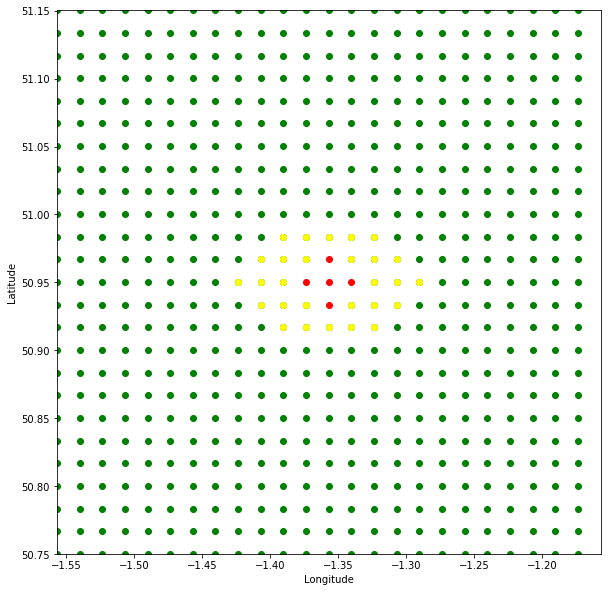

In [37]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.set(xlabel='X', ylabel='Y', aspect=1.0)
ax.scatter(df[df['UAS restriction']==True]['Longitude'],df[df['UAS restriction']==True]['Latitude'],color='red')
ax.scatter(df[df['UAS restriction']==False]['Longitude'],df[df['UAS restriction']==False]['Latitude'],color='green')
ax.scatter(df[df['UAS warning']==True]['Longitude'],df[df['UAS warning']==True]['Latitude'],color='yellow')

ax.set_xlim([x_start, x_end ])
ax.set_ylim([y_start, y_end ])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.plot(Southampton['Latitude'].values,Southampton['Longitude'].values,color='black',marker='*',markersize=20)
plt.show()

In [40]:
import pandas as pd
import folium

folium_map = folium.Map(location=[ 50.95029831,-1.35679996],
                        zoom_start=13)

folium.Circle(location=[y0,x0],fill=True,radius=2000).add_to(folium_map)



restriction = df[df['UAS restriction']==True]
restriction.apply(lambda x: folium.CircleMarker(location=[x['Latitude'],x['Longitude'] ],fill=True,radius=7,color='red').add_to(folium_map),axis=1)

safe = df[df['UAS restriction']==False]
safe.apply(lambda x: folium.CircleMarker(location=[x['Latitude'],x['Longitude'] ],fill=True,radius=7,color='green').add_to(folium_map),axis=1)

warning = df[df['UAS warning']==True]
warning.apply(lambda x: folium.CircleMarker(location=[x['Latitude'],x['Longitude'] ],fill=True,radius=7,color='yellow').add_to(folium_map),axis=1)




folium_map

In [6]:
def get_geojson_grid(upper_right, lower_left, n=6):
    """Returns a grid of geojson rectangles, and computes the exposure in each section of the grid based on the vessel data.

    Parameters
    ----------
    upper_right: array_like
        The upper right hand corner of "grid of grids" (the default is the upper right hand [lat, lon] of the USA).

    lower_left: array_like
        The lower left hand corner of "grid of grids"  (the default is the lower left hand [lat, lon] of the USA).

    n: integer
        The number of rows/columns in the (n,n) grid.

    Returns
    -------

    list
        List of "geojson style" dictionary objects   
    """

    all_boxes = []

    lat_steps = np.linspace(lower_left[0], upper_right[0], n+1)
    lon_steps = np.linspace(lower_left[1], upper_right[1], n+1)

    lat_stride = lat_steps[1] - lat_steps[0]
    lon_stride = lon_steps[1] - lon_steps[0]

    for lat in lat_steps[:-1]:
        for lon in lon_steps[:-1]:
            # Define dimensions of box in grid
            upper_left = [lon, lat + lat_stride]
            upper_right = [lon + lon_stride, lat + lat_stride]
            lower_right = [lon + lon_stride, lat]
            lower_left = [lon, lat]

            # Define json coordinates for polygon
            coordinates = [
                upper_left,
                upper_right,
                lower_right,
                lower_left,
                upper_left
            ]

            geo_json = {"type": "FeatureCollection",
                        "properties":{
                            "lower_left": lower_left,
                            "upper_right": upper_right
                        },
                        "features":[]}

            grid_feature = {
                "type":"Feature",
                "geometry":{
                    "type":"Polygon",
                    "coordinates": [coordinates],
                }
            }

            geo_json["features"].append(grid_feature)

            all_boxes.append(geo_json)

    return all_boxes


In [45]:
lower_left = [y0-0.1, x0-0.1]
upper_right = [y0+0.1, x0+0.1]
m = folium.Map(zoom_start = 13, location=[y0,x0])
grid = get_geojson_grid(upper_right, lower_left , n=6)


import matplotlib as mpl

for i, geo_json in enumerate(grid):

    color = plt.cm.Reds(i / len(grid))
    color = mpl.colors.to_hex(color)

    gj = folium.GeoJson(geo_json,
                        style_function=lambda feature, color=color: {
                                                                        'fillColor': color,
                                                                        'color':"black",
                                                                        'weight': 2,
                                                                        'dashArray': '5, 5',
                                                                        'fillOpacity': 0.55,
                                                                    })
    popup = folium.Popup("example popup {}".format(i))
    gj.add_child(popup)

    m.add_child(gj)
m